## Introduction

Detect fraudulent emails.

In [1]:
# Enter the s3 path of the input data file
s3_source_file="s3://bucket/mycsv.csv"

In [2]:
# Enter the s3 path of the output data file
bucket = 'aegovansagemaker' # Replace with your own bucket name if needed, this is the destination bucket
prefix = 'cs_emailfraud/sagemaker' 

## Setup

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting. If you don't specify a bucket, SageMaker SDK will create a default bucket following a pre-defined naming convention in the same region. 
- The IAM role ARN used to give SageMaker access to your data. It can be fetched using the **get_execution_role** method from sagemaker python SDK.

In [ ]:
!pip install scikit-plot==0.3.7
!pip install numpy==1.15.1
!pip install matplotlib==2.7.3
!pip install scikit-learn==0.20.0
!pip install nltk==3.3
!pip install pandas==0.22.0
!pip install sagemaker==1.10.1  


In [3]:
import sagemaker
from sagemaker import get_execution_role
import json
import boto3

sess = sagemaker.Session()

role = get_execution_role()


### Download data from S3

In [73]:
local_tmp_dir="tmp"
inputfile="{}/data.csv".format(local_tmp_dir)
!mkdir -p local_tmp_dir

In [5]:

!aws s3 cp $s3_source_file $inputfile

download: s3://aegovansagemaker/carsales-fraud-extract-extended.csv to tmp/data.csv


In [74]:
!head $inputfile


1,2017-08-22,1b3bd899-6da7-45be-b658-702de4c6a727,58294161-a033-4beb-8f58-c15725d936d9,your kidding me.. thats a bomb.. $100 if even that mate.. jesus,1,"Custom - CARS - Enquiry with Lexical Phrase or Word - SUSPECT
(NULTP) - SUSPECT

2,2017-08-22,886fce7b-45f7-49c5-81f4-407052e191c2,b15a2568-a1b6-4ce7-ad69-502782a1588b,Wondering if you may be interested in putting your boat on consignment with us at dAboras Marina The Spit any interest p[lease call,1,"(VXBE4) - NOTE
Negative IP Address - SUSPECT
(BRWTP) - NOTE

3,2017-08-22,9f02194b-8b97-43a8-8686-01ddcdc5b047,9e1a75e4-08bf-4a4b-bd20-6ca0a25c1461,Would you be interested in putting your boat on consignment with us at dAlboras marina The Spit,1,"(VXBE4) - NOTE
Negative IP Address - SUSPECT


### Prepare the dataset

Reformat the file as expected by blazing text with no header

In [75]:
import csv
import nltk


def get_data(inputfile):
    nltk.download('punkt')
    data = []
    with open(inputfile, "r") as i:
        csv_reader = csv.reader(i, delimiter=",", quotechar='"')
        # Ignore head
        next(csv_reader)
        for l in csv_reader:
            raw_label= l[5]
            label="__label__{}".format(raw_label)
            # Features - Comments, Make, Model , Year, Price
            text = "{} {} {} {} {}".format(l[4], l[11], l[12], l[13], l[14]).replace("\n", "")
            tokens = nltk.word_tokenize(text.lower())      
            data.append({"label" : raw_label, "text":text, "tokens": tokens})

    return data
        


   
        
    

In [76]:

data_list = get_data(inputfile)


[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Analyse the dataset

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.DataFrame(data_list)


In [78]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 10000)
pd.set_option('display.max_rows', 100)

In [79]:
print("Total no of records in the dataset {}".format(data.shape[0]))

Total no of records in the dataset 64045


In [80]:
data.head(n=3)

,label,text,tokens
0,1,your kidding me.. thats a bomb.. $100 if even that mate.. jesus Holden Commodore 2002 3000.00,"[your, kidding, me.., thats, a, bomb.., $, 100, if, even, that, mate.., jesus, holden, commodore, 2002, 3000.00]"
1,1,Wondering if you may be interested in putting your boat on consignment with us at dAboras Marina The Spit any interest p[lease call Sea Ray 355 Sundancer 2005 124880.00,"[wondering, if, you, may, be, interested, in, putting, your, boat, on, consignment, with, us, at, daboras, marina, the, spit, any, interest, p, [, lease, call, sea, ray, 355, sundancer, 2005, 124880.00]"
2,1,Would you be interested in putting your boat on consignment with us at dAlboras marina The Spit Sea Ray 275 SUNDANCER 2005 54000.00,"[would, you, be, interested, in, putting, your, boat, on, consignment, with, us, at, dalboras, marina, the, spit, sea, ray, 275, sundancer, 2005, 54000.00]"


Let us inspect the dataset and the classes to get some understanding about how the data and the label is provided in the dataset. 

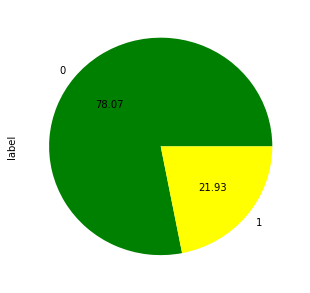

In [81]:
data["label"].value_counts().plot.pie(autopct='%.2f',figsize=(5, 5), colors=["green","yellow"])
plt.title = "Fraud class distribution"
plt.show()

In [82]:
num_classes = data["label"].nunique()

Split Data into Train, Test and Validation

In [83]:
from sklearn.model_selection import train_test_split, learning_curve
train_test, validation = train_test_split(data, test_size = 0.2, random_state = 777)
train, test = train_test_split(train_test, test_size = 0.2, random_state = 777)

View the class distribution for the train and validation set

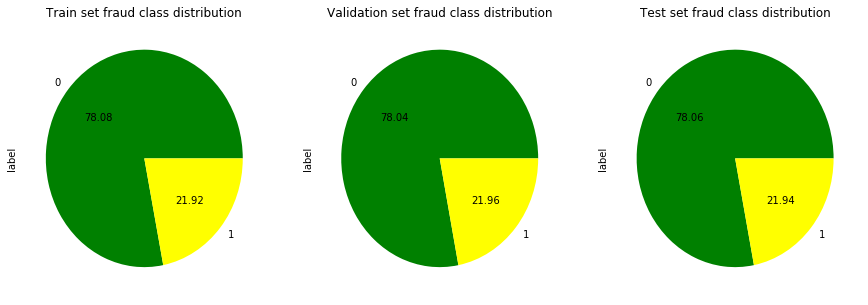

In [86]:
fig, ax = plt.subplots( 1,3, figsize=(15,5))
axis=ax[0]
train["label"].value_counts().plot.pie(autopct='%.2f', colors=["green","yellow"], ax=axis)
axis.set_title("Train set fraud class distribution")

axis=ax[1]
validation["label"].value_counts().plot.pie(autopct='%.2f', colors=["green","yellow"], ax=axis)
axis.set_title("Validation set fraud class distribution")


axis=ax[2]
test["label"].value_counts().plot.pie(autopct='%.2f', colors=["green","yellow"], ax=axis)
axis.set_title("Test set fraud class distribution")
plt.show()

#### Prepare the dataset file for Blazing text
The first column should be the label formatted as \__label__<labelname\>

In [87]:
import csv

def write_formatted_file(data, outputfile):
    with open(outputfile , "w") as o:
        for index, row in data.iterrows():
            label="__label__{}".format(row["label"])
            token_sep_space=" ".join(row["tokens"])
            o.write("{} {}\n".format(label, token_sep_space))

In [88]:
from sklearn.model_selection import train_test_split, learning_curve


formatted_train_file="{}/train.txt".format(local_tmp_dir)
formatted_validation_file="{}/validation.txt".format(local_tmp_dir)
formatted_test_file="{}/test.txt".format(local_tmp_dir)



write_formatted_file(train, formatted_train_file)
write_formatted_file(validation, formatted_validation_file)
write_formatted_file(test, formatted_test_file)

This is how the formatted file looks like.

In [89]:
!head $formatted_train_file

__label__0 hi , just like to know if there is any scratches or dents as the photo ’ s are misleading on one size . kia rio 2010 8000.00
__label__0 could you please share details if available with you ? is car serviced regularly as per manufacturer recommend scheduled ? when it is last serviced and when is due for next service ? is it going to be major service or minor ? is car timing ( alternaor ) belt have been changed or due for change in immediate future ? is car brack pad and disc has been changed or due for changes ? toyota kluger 2006 9500.00
__label__0 null nissan patrol 2013 34950.00
__label__0 hello emanuel i ’ m interested in your advertisement for hond civic , i tried to call you many times you weren ’ t available , please answer and call me if you ’ d like to sell your car . honda civic 2014 14900.00
__label__0 hi is the car still for sale call lenny on 0418972176 toyota fortuner 2015 36500.00
__label__0 neg/ ? hyundai ix35 2011 12200.00
__label__0 interested in having a lo

The data preprocessing cell might take a minute to run. After the data preprocessing is complete, we need to upload it to S3 so that it can be consumed by SageMaker to execute training jobs. We'll use Python SDK to upload these two files to the bucket and prefix location that we have set above.   

In [90]:
%%time

train_channel = prefix + '/train'
validation_channel = prefix + '/validation'

sess.upload_data(path=formatted_train_file, bucket=bucket, key_prefix=train_channel)
sess.upload_data(path=formatted_validation_file, bucket=bucket, key_prefix=validation_channel)

s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_validation_data = 's3://{}/{}'.format(bucket, validation_channel)


CPU times: user 336 ms, sys: 40 ms, total: 376 ms
Wall time: 653 ms


Next we need to setup an output location at S3, where the model artifact will be dumped. These artifacts are also the output of the algorithm's traning job.

In [91]:
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)

## Training
Now that we are done with all the setup that is needed, we are ready to train our object detector. To begin, let us create a ``sageMaker.estimator.Estimator`` object. This estimator will launch the training job.

In [92]:
region_name = boto3.Session().region_name
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'blazingtext')

## Training the BlazingText model for supervised text classification

In [56]:
bt_model = sagemaker.estimator.Estimator(container,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.c4.4xlarge',
                                         train_volume_size = 30,
                                         train_max_run = 360000,
                                         input_mode= 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

Please refer to [algorithm documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext_hyperparameters.html) for the complete list of hyperparameters.

In [57]:
bt_model.set_hyperparameters(mode="supervised",
                            epochs=600,
                            min_count=2,
                            learning_rate=0.05,
                            vector_dim=150,
                            early_stopping=True,
                            patience=50,
                            min_epochs=5,
                            subwords=False,
                            word_ngrams=3)

Now that the hyper-parameters are setup, let us prepare the handshake between our data channels and the algorithm. To do this, we need to create the `sagemaker.session.s3_input` objects from our data channels. These objects are then put in a simple dictionary, which the algorithm consumes.

In [58]:
train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='text/plain', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_data, distribution='FullyReplicated', 
                             content_type='text/plain', s3_data_type='S3Prefix')
data_channels = {'train': train_data, 'validation': validation_data}

In [59]:
bt_model.fit(inputs=data_channels, logs=True)

INFO:sagemaker:Creating training-job with name: blazingtext-2018-10-11-22-50-34-385


............
Arguments: train
[10/11/2018 22:52:30 WARNING 139975463876416] Loggers have already been setup.
[10/11/2018 22:52:30 WARNING 139975463876416] Loggers have already been setup.
[10/11/2018 22:52:30 INFO 139975463876416] nvidia-smi took: 0.0252070426941 secs to identify 0 gpus
[10/11/2018 22:52:30 INFO 139975463876416] Running single machine CPU BlazingText training using supervised mode.
[10/11/2018 22:52:30 INFO 139975463876416] Processing /opt/ml/input/data/train/train.txt . File size: 8 MB
[10/11/2018 22:52:30 INFO 139975463876416] Processing /opt/ml/input/data/validation/validation.txt . File size: 2 MB
Read 1M words
Number of words:  15583
Loading validation data from /opt/ml/input/data/validation/validation.txt
Loaded validation data.
-------------- End of epoch: 1
-------------- End of epoch: 2
-------------- End of epoch: 3
-------------- End of epoch: 4
-------------- End of epoch: 5
Using 16 threads for prediction!
Validation accuracy: 0.954641
Validation accuracy 


Billable seconds: 197


In [60]:
%%time
import boto3
from time import gmtime, strftime
sagemaker_session = sagemaker.Session()
model_name="blazingtextemailfraud" + '-model-' +  strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(model_name)

chainer_training_job = bt_model.latest_training_job.name
desc = sagemaker_session.sagemaker_client.describe_training_job(TrainingJobName=chainer_training_job)
model_data = desc['ModelArtifacts']['S3ModelArtifacts']

print(model_data)

primary_container = {
    'Image': container,
    'ModelDataUrl': model_data
}

client = boto3.client('sagemaker')
create_model_response = client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

blazingtextemailfraud-model-2018-10-11-22-59-55
s3://aegovansagemaker/cs_emailfraud/sagemaker/output/blazingtext-2018-10-11-22-50-34-385/output/model.tar.gz
arn:aws:sagemaker:us-east-2:324346001917:model/blazingtextemailfraud-model-2018-10-11-22-59-55
CPU times: user 52 ms, sys: 4 ms, total: 56 ms
Wall time: 337 ms


## Hyperparamter Tuning to optimise even further..

In [99]:
tuning_job_config = {
    "ParameterRanges": {
      "CategoricalParameterRanges": [],
      "ContinuousParameterRanges": [
       
        {
          "MaxValue": ".08",
          "MinValue": ".01",
          "Name": "learning_rate"
        }
      ],
      "IntegerParameterRanges": [
        {
          "MaxValue": "1000",
          "MinValue": "200",
          "Name": "epochs"
        },
          
        {
          "MaxValue": "10",
          "MinValue": "2",
          "Name": "min_count"
        },
           {
          "MaxValue": "400",
          "MinValue": "50",
          "Name": "vector_dim"
        },
          
      ]
    },
    "ResourceLimits": {
      "MaxNumberOfTrainingJobs": 20,
      "MaxParallelTrainingJobs": 3
    },
    "Strategy": "Bayesian",
    "HyperParameterTuningJobObjective": {
      "MetricName": "validation:accuracy",
      "Type": "Maximize"
    }
  }

In [100]:

     
training_job_definition = {
    "AlgorithmSpecification": {
      "TrainingImage": container,
      "TrainingInputMode": "File"
    },
    "InputDataConfig": [
      {
        "ChannelName": "train",
        "CompressionType": "None",
        "ContentType": "text/plain",
        "DataSource": {
          "S3DataSource": {
            "S3DataDistributionType": "FullyReplicated",
            "S3DataType": "S3Prefix",
            "S3Uri": s3_train_data
          }
        }
      },
      {
        "ChannelName": "validation",
        "CompressionType": "None",
        "ContentType": "text/plain",
        "DataSource": {
          "S3DataSource": {
            "S3DataDistributionType": "FullyReplicated",
            "S3DataType": "S3Prefix",
            "S3Uri": s3_validation_data
          }
        }
      }
    ],
    "OutputDataConfig": {
      "S3OutputPath": "s3://{}/{}/output".format(bucket,prefix)
    },
    "ResourceConfig": {
      "InstanceCount": 1,
      "InstanceType": "ml.c4.4xlarge",
      "VolumeSizeInGB": 10
    },
    "RoleArn": role,
    "StaticHyperParameters": {
        "mode":"supervised",
        "early_stopping":"True",
        "patience":"50",
        "min_epochs":"5"
    },
    "StoppingCondition": {
      "MaxRuntimeInSeconds": 43200
    }
}


In [101]:
from time import gmtime, strftime

tuning_job_name = "blazingtextemail-" + strftime("%Y%m%d%H%M%S", gmtime())
smclient = boto3.Session().client('sagemaker')

smclient.create_hyper_parameter_tuning_job(HyperParameterTuningJobName = tuning_job_name,
                                           HyperParameterTuningJobConfig = tuning_job_config,
                                           TrainingJobDefinition = training_job_definition)

{'HyperParameterTuningJobArn': 'arn:aws:sagemaker:us-east-2:324346001917:hyper-parameter-tuning-job/blazingtextemail-20181015052503',
 'ResponseMetadata': {'RequestId': 'b4e53cf7-adad-4252-991f-3f5a443aebd2',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'b4e53cf7-adad-4252-991f-3f5a443aebd2',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '132',
   'date': 'Mon, 15 Oct 2018 05:25:03 GMT'},
  'RetryAttempts': 0}}

## Inference using sagemaker batch transform

In [61]:
batchfileinput="{}/batchtest.json".format(local_tmp_dir)
batchfileoutput="{}/batchtest.output.json".format(local_tmp_dir)


#### Create a json file that is formatted  for blazing text inference
It kind of looks like
```json
{
  "instances": ["hey mate , very interested in this", "does it include a pakc ?", "hi is it working"],
  "configuration": {
    "k": 2
  }
}
```

In [62]:
%%time

import json
from itertools import islice
import math
import struct
import json

test_data = test

input_records = [" ".join(l["tokens"]) for index, l in test_data.iterrows()]
labels = ["__label__{}".format(l["label"]) for index, l  in test_data.iterrows() ]

input_json = {"instances" : input_records, "configuration": {"k": num_classes}}
with open(batchfileinput , "w") as f:
    f.write(json.dumps(input_json))
                                          

CPU times: user 1.74 s, sys: 24 ms, total: 1.77 s
Wall time: 1.77 s


In [63]:
%%time
import boto3
import sagemaker
import json

fmttime= strftime("%Y-%m-%d-%H-%M-%S", gmtime())
input_key_file="batchvalidation.csv"
input_batch_key="{}/batchTransform/{}_input/{}".format(prefix, fmttime, input_key_file)
input_location = 's3://{}/{}'.format(bucket, input_batch_key)
output_batch_key = "{}/batchTransform/{}_output".format(prefix,fmttime)
output_location = 's3://{}/{}'.format(bucket, output_batch_key)


s3_client = boto3.client('s3')
s3_client.upload_file(batchfileinput, bucket, input_batch_key)

# Initialize the transformer object
transformer =sagemaker.transformer.Transformer(
    base_transform_job_name='Batch-Transform',
    model_name=model_name,
    instance_count=1,
    instance_type='ml.c4.xlarge',
    output_path=output_location
    )
# To start a transform job:
transformer.transform(input_location, content_type='application/json')
# Then wait until transform job is completed
transformer.wait()

# To fetch validation result 
outputkey ='{}/{}.out'.format(output_batch_key, input_key_file)
print(outputkey)
s3_client.download_file(bucket, outputkey, batchfileoutput)



INFO:sagemaker:Creating transform job with name: Batch-Transform-2018-10-11-23-00-07-469


...................................!
cs_emailfraud/sagemaker/batchTransform/2018-10-11-23-00-07_output/batchvalidation.csv.out
CPU times: user 220 ms, sys: 20 ms, total: 240 ms
Wall time: 2min 57s


In [64]:
import json

with open(batchfileoutput) as f:
    predicted = json.load(f)



The output of Blazing text inference looks like this
```json
[{
    'prob': [0.9910072088241577, 0.00901278480887413],
    'label': ['__label__0', '__label__1']
  }, {
    'prob': [0.9973444938659668, 0.002675538882613182],
    'label': ['__label__1', '__label__0']
  }, {
    'prob': [0.9969576001167297, 0.003062397940084338],
    'label': ['__label__0', '__label__1']
  ]
]
```

So lets format it so that we can analyse the performance

In [65]:
predicted_labels = [ r['label'][r['prob'].index(max(r['prob']))] for r in predicted]
predicted_confidence_score = [ max(r['prob'])/sum(r['prob']) for r in predicted]



Convert the label format \__label__1 to 1 , as the scores work on numeric labels only

In [66]:
import pandas as pd

y_actual = pd.DataFrame(labels, columns = ["label"]) #== "__label__1"
y_pred = pd.DataFrame(predicted_labels, columns = ["predicted_label"]) #== "__label__1"
y_confidence_score =  pd.DataFrame(predicted_confidence_score, columns = ["predicted_label_confidence_score"])

In [67]:
import numpy as np
unique_classes = predicted[0]['label']

y_classwise_prob = pd.DataFrame(0, index=np.arange(len(predicted)), columns=unique_classes)
for c in unique_classes:
    y_classwise_prob[c] = pd.DataFrame([ r['prob'][r['label'].index(c)]/sum(r['prob']) for r in predicted])



### Evaluate the performance

In [68]:
positive_label="__label__1"

In [69]:


y_display= pd.DataFrame()
y_display["predicted_label"] = y_pred["predicted_label"]
y_display['confidence_score'] = y_confidence_score["predicted_label_confidence_score"]
y_display['score_postive_class'] = y_classwise_prob["__label__1"]
y_display['actual'] = y_actual['label']
y_display.head(n=10)



,predicted_label,confidence_score,score_postive_class,actual
0,__label__0,0.993730,0.006270,__label__0
1,__label__1,0.999951,0.999951,__label__1
2,__label__0,0.974258,0.025742,__label__0
3,__label__0,0.999912,0.000088,__label__0
4,__label__0,0.999988,0.000012,__label__0
5,__label__0,0.999980,0.000020,__label__0
6,__label__0,0.999990,0.000010,__label__1
7,__label__0,0.999672,0.000328,__label__0
8,__label__0,0.999990,0.000010,__label__0
9,__label__0,0.999798,0.000202,__label__0


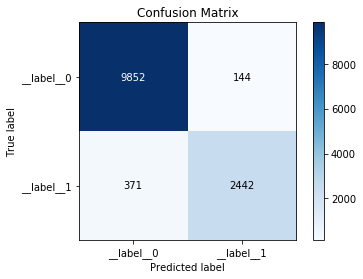

In [70]:
import scikitplot as skplt
import matplotlib.pyplot as plt

skplt.metrics.plot_confusion_matrix(y_actual, y_pred, labels=None, true_labels=None, pred_labels=None, title=None, normalize=False, hide_zeros=False, hide_counts=False, x_tick_rotation=0, ax=None, figsize=None, cmap='Blues', title_fontsize='large', text_fontsize='medium')
plt.show()

In [71]:
import sklearn
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_recall_fscore_support
import numpy as np

## Precision recall
macro_score = sklearn.metrics.average_precision_score( y_actual, y_classwise_prob[positive_label] ,  pos_label = "__label__1")
f1score = sklearn.metrics.f1_score(y_actual, y_pred , pos_label = positive_label, average='binary')
precision = sklearn.metrics.precision_score(y_actual, y_pred ,  pos_label = positive_label, average='binary')
recall = sklearn.metrics.recall_score( y_actual, y_pred ,  pos_label = positive_label, average='binary')

## Unweighted ROC
acc = accuracy_score(y_actual, y_pred)
fpr, tpr, _ = roc_curve(y_actual,y_classwise_prob[positive_label], pos_label=positive_label)
roc_auc = auc(fpr, tpr)

print("The AUC under precision recall curve is {}".format( macro_score))
print("F1 score {}".format(f1score))
print("Precision score {}".format(precision))
print("Recall score {}".format(recall))
print("Accuracy {}".format( acc))
print("Area Under ROC curve {}".format( roc_auc))



The AUC under precision recall curve is 0.946342109148212
F1 score 0.9046119651787368
Precision score 0.9443155452436195
Recall score 0.868112335584785
Accuracy 0.959793894917636
Area Under ROC curve 0.966680362155527


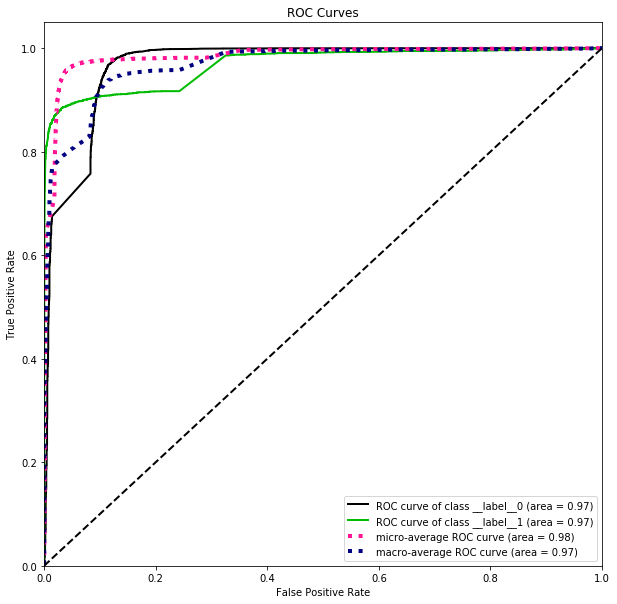

In [38]:
import scikitplot as skplt
import matplotlib.pyplot as plt

y_true =  y_actual# ground truth labels
skplt.metrics.plot_roc(y_true, y_classwise_prob, figsize=(10,10))
plt.show()